## conv autoencoder for mnist denoising

In [10]:
from tensorflow.examples.tutorials.mnist.input_data import read_data_sets
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, Sequential
from keras.callbacks import TensorBoard, ModelCheckpoint

## prepare data

In [11]:
dataset_dir = os.path.join(os.path.expanduser('~'), 'bitbucket/test_data/mnist')
dataset = read_data_sets(dataset_dir)
train_images, train_labels = dataset.train.images, dataset.train.labels
test_images, test_labels = dataset.test.images, dataset.test.labels
train_images = np.asarray(train_images, dtype='float32').reshape((-1, 28, 28, 1))
test_images = np.asarray(test_images, dtype='float32').reshape((-1, 28, 28, 1))
print(train_images.shape, test_images.shape)
print(np.max(test_images), np.min(test_images))

Extracting /home/xtalpi/bitbucket/test_data/mnist/train-images-idx3-ubyte.gz
Extracting /home/xtalpi/bitbucket/test_data/mnist/train-labels-idx1-ubyte.gz
Extracting /home/xtalpi/bitbucket/test_data/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/xtalpi/bitbucket/test_data/mnist/t10k-labels-idx1-ubyte.gz
((55000, 28, 28, 1), (10000, 28, 28, 1))
(1.0, 0.0)


## add noise

In [19]:
noise_factor = 0.5
train_images_noisy = train_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_images.shape).astype(np.float32) 
test_images_noisy = test_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_images.shape).astype(np.float32)
train_images_noisy = np.clip(train_images_noisy, 0., 1.)
test_images_noisy = np.clip(test_images_noisy, 0., 1.)

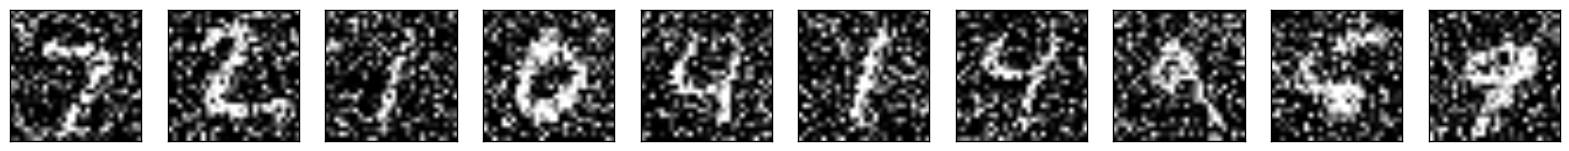

In [20]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(test_images_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## build conv autoencoder

In [21]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [27]:
import joblib
log_dir = os.path.join(dataset_dir, 'conv_autoencoder')
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
config_file = os.path.join(log_dir, 'config.joblib')
hdf5_file = os.path.join(log_dir, 'weights.hdf5')

joblib.dump(autoencoder.get_config(), config_file)
checkpoint = ModelCheckpoint(hdf5_file, save_best_only=True, period=10)
tensorboard = TensorBoard(log_dir, histogram_freq=1)
autoencoder.fit(train_images_noisy[:1000], train_images[:1000],
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(test_images_noisy, test_images),
                callbacks=[tensorboard, checkpoint])

Train on 1000 samples, validate on 10000 samples
INFO:tensorflow:Summary name conv2d_11/kernel:0 is illegal; using conv2d_11/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_11/bias:0 is illegal; using conv2d_11/bias_0 instead.
INFO:tensorflow:Summary name conv2d_12/kernel:0 is illegal; using conv2d_12/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_12/bias:0 is illegal; using conv2d_12/bias_0 instead.
INFO:tensorflow:Summary name conv2d_13/kernel:0 is illegal; using conv2d_13/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_13/bias:0 is illegal; using conv2d_13/bias_0 instead.
INFO:tensorflow:Summary name conv2d_14/kernel:0 is illegal; using conv2d_14/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_14/bias:0 is illegal; using conv2d_14/bias_0 instead.
INFO:tensorflow:Summary name conv2d_15/kernel:0 is illegal; using conv2d_15/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_15/bias:0 is illegal; using conv2d_15/bias_0 instead.
Epoch 1/100
 896/1000 [========

InvalidArgumentError: You must feed a value for placeholder tensor 'input_1' with dtype float
	 [[Node: input_1 = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op u'input_1', defined at:
  File "/home/xtalpi/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/xtalpi/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/xtalpi/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/xtalpi/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/home/xtalpi/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/xtalpi/anaconda2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/xtalpi/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/xtalpi/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/xtalpi/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/xtalpi/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/xtalpi/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/xtalpi/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/xtalpi/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/xtalpi/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/xtalpi/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/xtalpi/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/xtalpi/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/xtalpi/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/xtalpi/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/xtalpi/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-98c2900c802f>", line 1, in <module>
    input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format
  File "/home/xtalpi/frameworks/keras/keras/engine/topology.py", line 1375, in Input
    input_tensor=tensor)
  File "/home/xtalpi/frameworks/keras/keras/engine/topology.py", line 1286, in __init__
    name=self.name)
  File "/home/xtalpi/frameworks/keras/keras/backend/tensorflow_backend.py", line 349, in placeholder
    x = tf.placeholder(dtype, shape=shape, name=name)
  File "/home/xtalpi/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/array_ops.py", line 1502, in placeholder
    name=name)
  File "/home/xtalpi/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2149, in _placeholder
    name=name)
  File "/home/xtalpi/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/home/xtalpi/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/xtalpi/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'input_1' with dtype float
	 [[Node: input_1 = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]
